In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
from model_utils import *

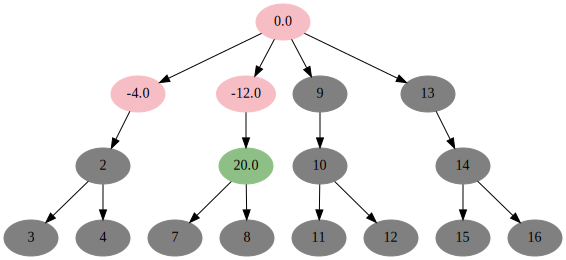

In [2]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

env = make_env(1.25)
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

# Linear softmax policy

Text(0.5,1,'Features for each action in the state shown above')

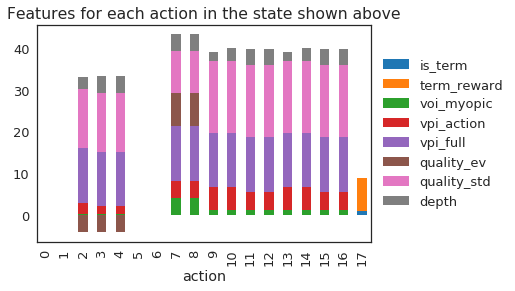

In [3]:
features = '''
is_term
term_reward
voi_myopic
vpi_action
vpi_full
quality_ev
quality_std
depth
'''.strip().split('\n')

from human_model import HumanPolicy

agent = Agent()
theta = np.ones(8)
pol = HumanPolicy(theta=theta, temp=1)
agent.register(env)
agent.register(pol)

phi = [pol.phi(env._state, action) 
       for action in range(env.term_action + 1)]

pd.DataFrame(phi, columns=features).plot.bar(stacked=True, legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('action')
plt.title('Features for each action in the state shown above')

# Optimize policy by evolution

In [20]:
envs = make_envs(1.25, n=100, ground_truth=2)
get_util(read_bo_policy(1.25), envs)

10.942500000000001

In [9]:
from evolution import EvolutionaryOptimizer

# envs = make_envs(1.25, n=100, ground_truth=1)

def loss(theta):
    return - get_util(HumanPolicy(theta), envs)

bounds = np.array([
    (0, 1), # is_term
    (0, 1),   # term_reward
    (0, 1),   # voi_myopic
    (0, 1),   # vpi_action
    (0, 1),   # vpi_full
    (0, 1),  # quality_ev
    (0, 1),  # quality_std
    (0, 1), # depth
]).T

# opt = EvolutionaryOptimizer(loss, tuple(bounds), size=5, gen=1)
# for _ in range(30):
#     opt.evolve()

evolve
evolve
evolve
evolve
evolve


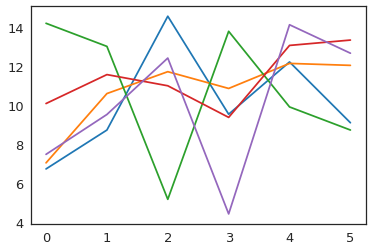

In [13]:
X = - np.stack(opt.fs)
plt.plot(X)

# Simulate experiment

In [21]:
from analysis_utils import *
df, pdf = load('1.8', base='exp-data')
COSTS = pdf.info_cost.unique()

# Load the reward structures used in the experiment.
exp_envs = {}
for cost in pdf.info_cost.unique():
    with open(f'exp-data/rewards_{cost:.2f}.json') as f:
        d = json.load(f)
        for trial in concatv(d['train'], d['test']):
            exp_envs[trial['trial_id']] = make_env(cost, ground_truth=trial['stateRewards'])

/home/fredcallaway/mcrl/analysis_utils.py:12: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  pdf['pr_type'] = pdf.PR_type.astype('category', categories=pr_types)


In [22]:
label = Labeler()
def simulate(policy, envs, seed=None):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    agent = Agent()
    agent.register(ENV)
    agent.register(policy)
    for trial_id, env in envs.items():
        agent.register(env)
        trace = agent.run_episode()
        for s, a in zip(trace['states'], trace['actions']):
            yield {'pid': seed, 'cost': abs(env.cost), 'trial_id': trial_id,
                   'state': label(s), 'action': a}
        

# alt_envs = dict(zip(range(100), make_envs(1.25, ground_truth=1)))
# sdf = pd.DataFrame(list(concat(simulate(pol, alt_envs, seed) 
#                           for seed, pol in zip(range(5), results))))
theta = np.array([ 0.489,  0.694,  0.214,  0.477,  0.357,  0.945,  0.003,  0.223])
pol = HumanPolicy(theta)
sdf = pd.DataFrame(simulate(pol, exp_envs))

# Fit human data

In [9]:
from analysis_utils import load
from model_utils import *
from toolz import *
from human_model import action_features

label = Labeler()
def expand():
    for i, row in df.iterrows():
        for s, a in zip(row.states, concatv(row.clicks, [ENV.term_action])):
            yield {'pid': row.pidx, 'cost': row.info_cost, 'pr_type': row.pr_type,
                   'state': label(parse_state(s)), 'action': a, 'trial_id': row.trial_id}

data = pd.DataFrame(expand())
data.head()

,action,cost,pid,pr_type,state,trial_id
0,1,1.25,0,none,0,8969
1,17,1.25,0,none,1,8969
2,5,1.25,0,none,0,9359
3,9,1.25,0,none,2,9359
4,1,1.25,0,none,3,9359


Likelihood:
$$p(D \mid \theta) = \prod_i^N p(a_i \mid s_i; \theta)$$

Softmax Q policy:
$$p(a \mid s; \theta) = \frac{\exp \{ Q(s, a; \theta) \} }{ \sum_{a'} \exp \{ Q(s, a'; \theta) \} }$$

Linear regression Q:
$$Q(s, a; \theta) = \theta^\top \phi(s, a)$$

Before performing inference, we precompute the features, storing them in a 3d tensor.
`phi[s, a, f]` will give the value $\phi(s, a)_f$


In [29]:
# pol = HumanPolicy([1, 1, 0, 0, 0, 1 ,1 ,1])
phi = np.array([[pol.phi(s, a) for a in range(env.term_action + 1)]
                 for s in label._xs])


In [33]:
data = sdf.query('cost == 1.25')

In [52]:
Q = np.dot(phi[data.state.as_matrix()], theta)
Q - Q.max(1).reshape(-1, 1)


array([[-14.127,  -0.223,   0.   , ...,  -0.451,  -0.451, -13.638],
       [-20.021, -12.927, -12.704, ..., -12.836, -12.836, -11.204],
       [-17.291, -10.864, -10.641, ..., -10.773, -10.773,  -8.474],
       ..., 
       [-17.291, -10.864, -10.641, ..., -10.773, -10.773,  -8.474],
       [-31.342, -30.054, -29.831, ..., -29.674, -29.674,  -8.645],
       [-25.473, -24.754, -24.531, ..., -24.336, -24.336,   0.   ]])

In [65]:
def logp(data, theta, temp=1):
    Q = np.dot(phi[data.state.as_matrix()], theta)
    Q -= Q.max(1).reshape(-1, 1)  # prevent float overflow 
    idx = np.arange(len(data))
    eq = np.exp(Q / temp)
    chosen = eq[idx, data.action.as_matrix()]
    return np.log(chosen / (eq.sum(1) + 1e-10)).sum()
    
# print(logp(np.r_[1, trace['theta'].mean(0)]))
print('true policy logp:', logp(data, theta, .0001))
print('random policy logp:', logp(data, theta, 1e10))

true policy logp: -56.7338368124
random policy logp: -355.515726098


In [70]:
%env MKL_THREADING_LAYER=GNU

env: MKL_THREADING_LAYER=GNU


In [71]:
import pymc3 as pm
import theano.tensor as tt

def run_model(data):
    n_pid = data.pid.max() + 1
    n_feature = len(phi[0,0])
    idx = np.arange(len(data))

    with pm.Model() as model:

        theta = pm.Normal('theta', 0, 5, shape=n_feature)
        temp = 1
        Q = tt.dot(phi[data.state.as_matrix()], theta)
        Q = Q - Q.max(1).reshape((len(data), 1))  # numerical stability
        eq = tt.exp(Q / temp)
        chosen = eq[idx, data.action.as_matrix()]
        likelihood = pm.Deterministic('likelihood', chosen / (eq.sum(1) + 1e-10))
        pm.Potential('logp', np.log(likelihood).sum())

        return pm.sample(njobs=10), model

trace, model = run_model(data)
    

AttributeError: module 'theano' has no attribute 'compile'

In [ ]:
pm.traceplot(trace)

In [ ]:
inferred_pol = HumanPolicy(np.r_[1, trace['theta'].mean(0)])
print(inferred_pol.theta)
print(results[0].theta)

In [ ]:
pm.summary(trace)